# Loan Classification Model

<center>
    <img src="https://miro.medium.com/max/1400/1*-MetoVHBJQjcbVhSEYBbvg.jpeg" width="1200" alt="cognitiveclass.ai logo"  />
</center>

In this notebook we try to predict loan state of our customers as a classification problem.

We load the dataset using Pandas library, and apply several algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


In [2]:
import jovian

In [3]:
jovian.commit("loan-classification-project") 

<IPython.core.display.Javascript object>

[jovian] Updating notebook "ramysaleem/ml0101en-proj-loan-py-v1" on https://jovian.ai
[jovian] Committed successfully! https://jovian.ai/ramysaleem/ml0101en-proj-loan-py-v1


'https://jovian.ai/ramysaleem/ml0101en-proj-loan-py-v1'

Let's download the dataset


In [4]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-10-18 09:47:04--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-10-18 09:47:04 (290 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [5]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [6]:
df.shape

(346, 10)

### Convert to date time object


In [7]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [8]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


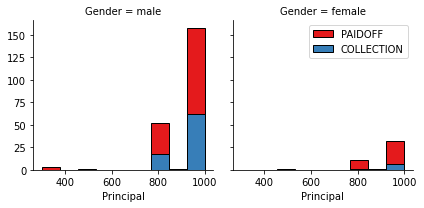

In [10]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

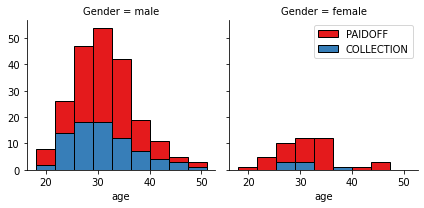

In [11]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


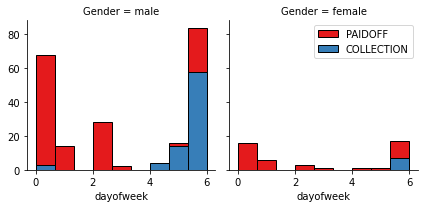

In [12]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [13]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [14]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [15]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [16]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [17]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [18]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [19]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [20]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [21]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [23]:
from sklearn.neighbors import KNeighborsClassifier

k = 7
#Train Model and Predict
kNN_model = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
kNN_model

KNeighborsClassifier(n_neighbors=7)

In [24]:
k = 3

kNN_model2 = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=k, p=2,
           weights='uniform')

In [25]:
kNN_model2.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [26]:
yhat = kNN_model.predict(X_test)
yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [27]:
yhat_2 = kNN_model2.predict(X_test)
yhat_2[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [28]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, kNN_model.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.8043478260869565
Test set Accuracy:  0.8


In [29]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, kNN_model2.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.8333333333333334
Test set Accuracy:  0.8


# Decision Tree


In [30]:
from sklearn.tree import DecisionTreeClassifier

In [31]:
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [32]:
tree_loan1 = DecisionTreeClassifier(criterion="entropy", max_depth = 5)
tree_loan1

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [33]:
tree_loan2 = DecisionTreeClassifier(max_depth=7, random_state=42)
tree_loan2

DecisionTreeClassifier(max_depth=7, random_state=42)

In [34]:
tree_loan1.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [35]:
tree_loan2.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=7, random_state=42)

In [36]:
tree_pred_Loan = tree_loan1.predict(X_test)
tree_pred_Loan

array(['COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'COLLECTION', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF'], dtype=object)

In [37]:
tree_pred_Loan2 = tree_loan2.predict(X_test)

In [38]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, tree_pred_Loan))

DecisionTrees's Accuracy:  0.6428571428571429


In [39]:
print("DecisionTrees's 2 Accuracy: ", metrics.accuracy_score(y_test, tree_pred_Loan2))

DecisionTrees's 2 Accuracy:  0.7571428571428571


# Support Vector Machine


In [40]:
from sklearn import svm
clf = svm.SVC(kernel='rbf', max_iter = -1)
clf.fit(X_train, y_train) 

SVC()

In [41]:
yhatSVM = clf.predict(X_test)
yhatSVM[0:10]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [42]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [43]:
y_train

array(['PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'COLLECTION', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF'

In [44]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [45]:
print("SVM Classifier Precision: ", precision_score(y_test, yhatSVM, average='macro'))

SVM Classifier Precision:  0.5885978428351311


In [46]:
print("SVM Classifier F1 Score: ", f1_score(y_test, yhatSVM, average='macro'))

SVM Classifier F1 Score:  0.5748987854251012


In [47]:
print("SVM Classifier Recall Score: ", recall_score(y_test, yhatSVM, average='macro'))

SVM Classifier Recall Score:  0.5696969696969697


In [48]:
print("SVM Classifier Accuracy: ", accuracy_score(y_test, yhatSVM))

SVM Classifier Accuracy:  0.7428571428571429


# Logistic Regression


In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [50]:
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

LogisticRegression()

In [51]:
y_predLR = logreg_model.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_model.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.73


# Random Forest Classifier

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
RanFor_model = RandomForestClassifier(n_jobs=-1, 
                               random_state=42, 
                               n_estimators=500,
                               max_depth=3)

In [54]:
RanFor_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [55]:
preds_RanFor = RanFor_model.predict(X_test)

In [56]:
print('Accuracy of Random Forest Classifier on train set: {:.2f}'.format(accuracy_score(y_test, preds_RanFor)))

Accuracy of Random Forest Classifier on train set: 0.79


# Model Evaluation using Test set

In [57]:
from sklearn.metrics import precision_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss

First, download and load the test set:


In [58]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-10-18 09:48:19--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-10-18 09:48:19 (542 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [59]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [60]:
test_y = test_df['loan_status'].values
print(test_y)

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'COLLECTION' 'COLLECTION' 'COLLECTION' 'COLLECTION' 'COLLECTION'
 'COLLECTION' 'COLLECTION' 'COLLECTION' 'COLLECTION' 'COLLECTION'
 'COLLECTION' 'COLLECTION' 'COLLECTION']


In [61]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
test_X = preprocessing.StandardScaler().fit(test_Feature).transform(test_Feature)
test_X[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

## Modelling

In [62]:
knn_yhat = kNN_model.predict(X_test)

print("KNN Precision Score: %.2f" % precision_score(y_test, knn_yhat, average='macro'))
print("KNN F1-score: %.2f" % f1_score(y_test, knn_yhat, average='weighted'))
print("KNN Recall Score: %.2f" % recall_score(y_test, knn_yhat, average='macro'))
print("KNN Accuracy Score: %.2f" % accuracy_score(y_test, knn_yhat))
print("KNN Jaccard Score: %.2f" % jaccard_score(y_test, knn_yhat, average='macro'))

KNN Precision Score: 0.70
KNN F1-score: 0.80
KNN Recall Score: 0.70
KNN Accuracy Score: 0.80
KNN Jaccard Score: 0.57


In [205]:
tree_yhat = tree_loan1.predict(X_test)
tree_yhat

array(['COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'COLLECTION', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF'], dtype=object)

In [64]:
print("Tree-1 Precision Score: %.2f" % precision_score(y_test, tree_yhat, average='macro'))
print("Tree-1 F1-score: %.2f" % f1_score(y_test, tree_yhat, average='weighted'))
print("Tree-1 Recall Score: %.2f" % recall_score(y_test, tree_yhat, average='macro'))
print("Tree-1 Accuracy Score: %.2f" % accuracy_score(y_test, tree_yhat))
print("Tree-1 Jaccard Score: %.2f" % jaccard_score(y_test, tree_yhat, average='macro'))

Tree-1 Precision Score: 0.60
Tree-1 F1-score: 0.67
Tree-1 Recall Score: 0.65
Tree-1 Accuracy Score: 0.64
Tree-1 Jaccard Score: 0.43


In [65]:
tree_yhat2 = tree_loan2.predict(X_test)

In [66]:
print("Tree-2 Precision Score: %.2f" % precision_score(y_test, tree_yhat2, average='macro'))
print("Tree-2 F1-score: %.2f" % f1_score(y_test, tree_yhat2, average='weighted'))
print("Tree-2 Recall Score: %.2f" % recall_score(y_test, tree_yhat2, average='macro'))
print("Tree-2 Accuracy Score: %.2f" % accuracy_score(y_test, tree_yhat2))
print("Tree-2 Jaccard Score: %.2f" % jaccard_score(y_test, tree_yhat2, average='macro'))

Tree-2 Precision Score: 0.57
Tree-2 F1-score: 0.71
Tree-2 Recall Score: 0.53
Tree-2 Accuracy Score: 0.76
Tree-2 Jaccard Score: 0.43


In [67]:
SVM_yhat = clf.predict(X_test)

In [68]:
print("SVM Precision Score: %.2f" % precision_score(y_test, SVM_yhat, average='macro'))
print("SVM F1-score: %.2f" % f1_score(y_test, SVM_yhat, average='weighted'))
print("SVM Recall Accuracy Score: %.2f" % recall_score(y_test, SVM_yhat, average='macro'))
print("SVM Accuracy Score: %.2f" % accuracy_score(y_test, SVM_yhat))
print("SVM Jaccard Score: %.2f" % jaccard_score(y_test, SVM_yhat, average='macro'))

SVM Precision Score: 0.59
SVM F1-score: 0.73
SVM Recall Accuracy Score: 0.57
SVM Accuracy Score: 0.74
SVM Jaccard Score: 0.45


In [69]:
logreg_yhat = logreg_model.predict(X_test)

In [70]:
print("LogisticRegression Precision Score: %.2f" % precision_score(y_test, logreg_yhat, average='macro'))
print("LogisticRegression F1-score: %.2f" % f1_score(y_test, logreg_yhat, average='weighted'))
print("LogisticRegression Recall Score: %.2f" % recall_score(y_test, logreg_yhat, average='macro'))
print("LogisticRegression Accuracy Score: %.2f" % accuracy_score(y_test, logreg_yhat))
print("LogisticRegression Jaccard Score: %.2f" % jaccard_score(y_test, logreg_yhat, average='macro'))

LogisticRegression Precision Score: 0.52
LogisticRegression F1-score: 0.70
LogisticRegression Recall Score: 0.51
LogisticRegression Accuracy Score: 0.73
LogisticRegression Jaccard Score: 0.41


In [71]:
RanFor_yhat = RanFor_model.predict(X_test)

In [72]:
print("RandomForest Precision Score: %.2f" % precision_score(y_test, RanFor_yhat, average='macro'))
print("RandomForest F1-score: %.2f" % f1_score(y_test, RanFor_yhat, average='weighted'))
print("RandomForest Recall Score: %.2f" % recall_score(y_test, RanFor_yhat, average='macro'))
print("RandomForest Accuracy Score: %.2f" % accuracy_score(y_test, RanFor_yhat))
print("RandomForest Jaccard Score: %.2f" % jaccard_score(y_test, RanFor_yhat, average='macro'))

RandomForest Precision Score: 0.39
RandomForest F1-score: 0.69
RandomForest Recall Score: 0.50
RandomForest Accuracy Score: 0.79
RandomForest Jaccard Score: 0.39


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Important Features from Tree model

In [73]:
from sklearn.tree import plot_tree, export_text

In [89]:
Feature.head(5)

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [90]:
model_text = export_text(tree_loan2, feature_names=list(Feature.columns))
print(model_text[:3000])

|--- weekend <= -0.19
|   |--- college <= 0.14
|   |   |--- class: PAIDOFF
|   |--- college >  0.14
|   |   |--- age <= 1.25
|   |   |   |--- terms <= -0.02
|   |   |   |   |--- class: PAIDOFF
|   |   |   |--- terms >  -0.02
|   |   |   |   |--- age <= -0.40
|   |   |   |   |   |--- age <= -0.57
|   |   |   |   |   |   |--- class: PAIDOFF
|   |   |   |   |   |--- age >  -0.57
|   |   |   |   |   |   |--- class: PAIDOFF
|   |   |   |   |--- age >  -0.40
|   |   |   |   |   |--- class: PAIDOFF
|   |   |--- age >  1.25
|   |   |   |--- age <= 1.42
|   |   |   |   |--- terms <= -0.02
|   |   |   |   |   |--- class: COLLECTION
|   |   |   |   |--- terms >  -0.02
|   |   |   |   |   |--- class: PAIDOFF
|   |   |   |--- age >  1.42
|   |   |   |   |--- class: PAIDOFF
|--- weekend >  -0.19
|   |--- age <= 0.26
|   |   |--- terms <= -1.46
|   |   |   |--- class: PAIDOFF
|   |   |--- terms >  -1.46
|   |   |   |--- age <= -1.98
|   |   |   |   |--- class: COLLECTION
|   |   |   |--- age >  -1.98

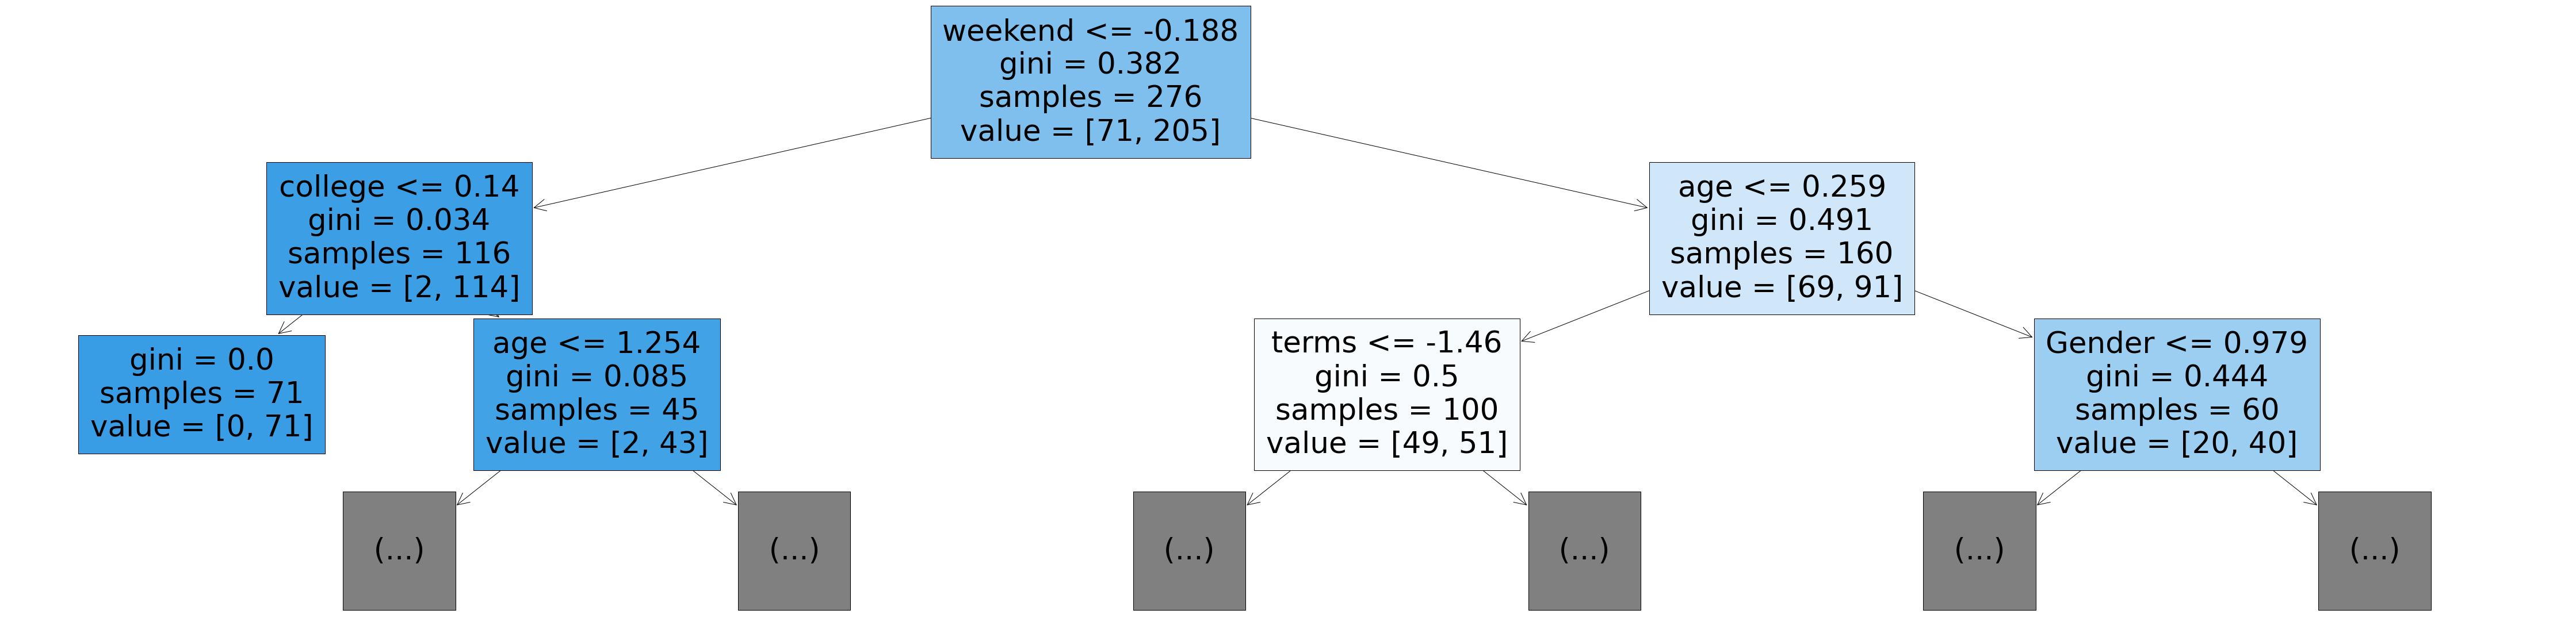

In [91]:
plt.figure(figsize=(80,20))
plot_tree(tree_loan2, feature_names=Feature.columns, max_depth=2, filled=True);

In [92]:
importance_df = pd.DataFrame({
    'feature': Feature.columns,
    'importance': tree_loan2.feature_importances_}).sort_values('importance', ascending=False)

In [93]:
importance_df

,feature,importance
4,weekend,0.525343
2,age,0.203870
1,terms,0.122724
3,Gender,0.078879
5,Bechalor,0.024938
6,High School or Below,0.021256
0,Principal,0.020510
7,college,0.002480


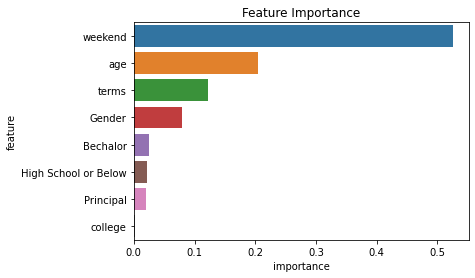

In [96]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

# Model Results

## Accuracy Score

In [168]:
knn_accuracy_score = accuracy_score(y_test, knn_yhat)
tree1_accuracy_score = accuracy_score(y_test, tree_yhat)
tree2_accuracy_score = accuracy_score(y_test, tree_yhat2)
svm_accuracy_score = accuracy_score(y_test, SVM_yhat)
logreg_accuracy_score = accuracy_score(y_test, logreg_yhat)
ranfor_accuracy_score = accuracy_score(y_test, RanFor_yhat)

In [169]:
results = pd.DataFrame({
    'Model':['KNN',
             'Tree_1',
            'Tree_2',
            'SVM',
             'LogReg',
             'RanFor'
            ],
    
    'Score':[knn_accuracy_score,
             tree1_accuracy_score,
             tree2_accuracy_score,
             svm_accuracy_score,
             logreg_accuracy_score,
            ranfor_accuracy_score
            ]})

sorted_result = results.sort_values(by='Score', ascending=False).reset_index(drop=True)
sorted_result.round(2)

,Model,Score
0,KNN,0.80
1,RanFor,0.79
2,Tree_2,0.76
3,SVM,0.74
4,LogReg,0.73
5,Tree_1,0.64


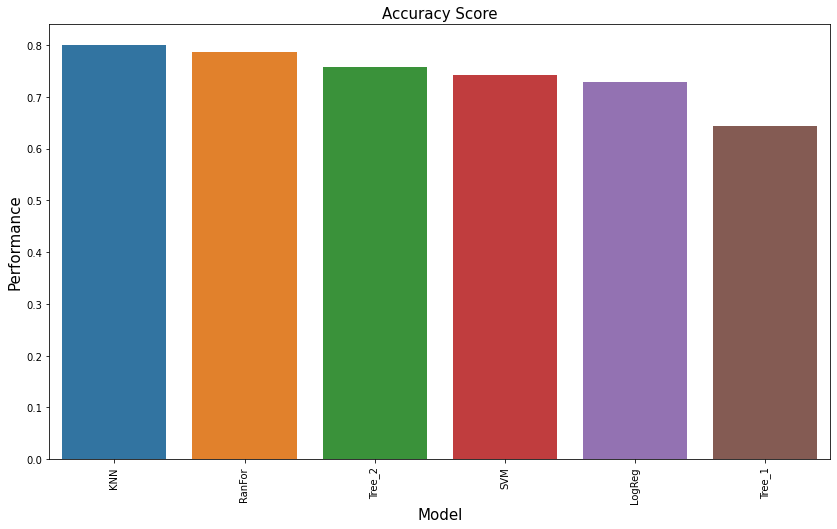

In [170]:
f, ax = plt.subplots(figsize=(14,8))
plt.xticks(rotation='90')
sns.barplot(x=sorted_result['Model'], y=sorted_result['Score'])
plt.xlabel('Model', fontsize=15)
plt.ylabel('Performance', fontsize=15)
#plt.ylim(0.10, 0.12)
plt.title('Accuracy Score', fontsize=15)
plt.show()

## Jaccard Score

In [171]:
knn_jaccard_score = jaccard_score(y_test, knn_yhat, average='macro')
tree1_jaccard_score = jaccard_score(y_test, tree_yhat, average='macro')
tree2_jaccard_score = jaccard_score(y_test, tree_yhat2, average='macro')
svm_jaccard_score = jaccard_score(y_test, SVM_yhat, average='macro')
logreg_jaccard_score = jaccard_score(y_test, logreg_yhat, average='macro')
ranfor_jaccard_score = jaccard_score(y_test, RanFor_yhat, average='macro')

In [173]:
results = pd.DataFrame({
    'Model':['KNN',
             'Tree_1',
            'Tree_2',
            'SVM',
             'LogReg',
             'RanFor'
            ],
    
    'Score':[knn_jaccard_score,
             tree1_jaccard_score,
             tree2_jaccard_score,
             svm_jaccard_score,
             logreg_jaccard_score,
            ranfor_jaccard_score
            ]})

sorted_result = results.sort_values(by='Score', ascending=False).reset_index(drop=True)
sorted_result.round(2)

,Model,Score
0,KNN,0.57
1,SVM,0.45
2,Tree_1,0.43
3,Tree_2,0.43
4,LogReg,0.41
5,RanFor,0.39


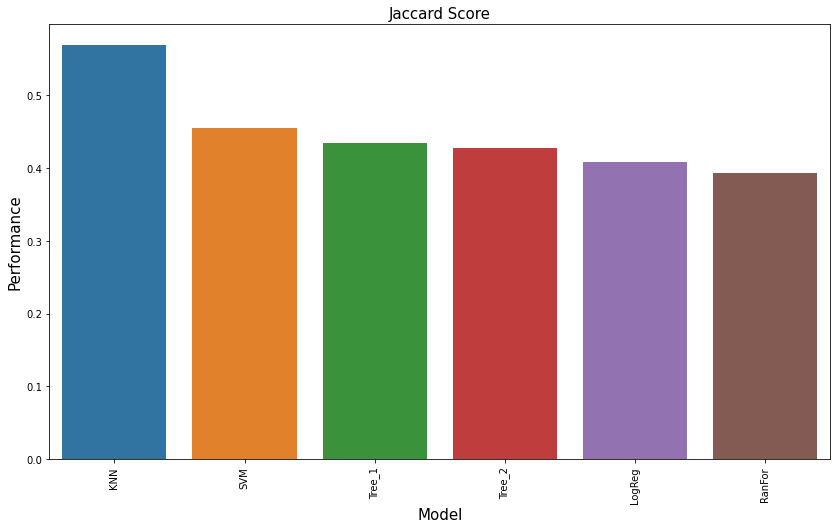

In [174]:
f, ax = plt.subplots(figsize=(14,8))
plt.xticks(rotation='90')
sns.barplot(x=sorted_result['Model'], y=sorted_result['Score'])
plt.xlabel('Model', fontsize=15)
plt.ylabel('Performance', fontsize=15)
#plt.ylim(0.10, 0.12)
plt.title('Jaccard Score', fontsize=15)
plt.show()

## F1 Score

In [175]:
knn_f1_score = f1_score(y_test, knn_yhat, average='macro')
tree1_f1_score = f1_score(y_test, tree_yhat, average='macro')
tree2_f1_score = f1_score(y_test, tree_yhat2, average='macro')
svm_f1_score = f1_score(y_test, SVM_yhat, average='macro')
logreg_f1_score = f1_score(y_test, logreg_yhat, average='macro')
ranfor_f1_score = f1_score(y_test, RanFor_yhat, average='macro')

In [176]:
results = pd.DataFrame({
    'Model':['KNN',
             'Tree_1',
            'Tree_2',
            'SVM',
             'LogReg',
             'RanFor'
            ],
    
    'Score':[knn_f1_score,
             tree1_f1_score,
             tree2_f1_score,
             svm_f1_score,
             logreg_f1_score,
            ranfor_f1_score
            ]})

sorted_result = results.sort_values(by='Score', ascending=False).reset_index(drop=True)
sorted_result.round(2)

,Model,Score
0,KNN,0.70
1,Tree_1,0.59
2,SVM,0.57
3,Tree_2,0.52
4,LogReg,0.51
5,RanFor,0.44


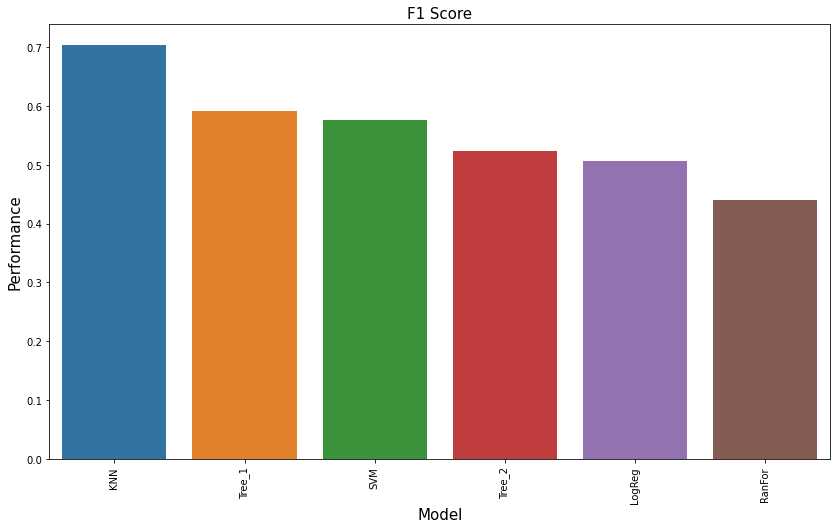

In [177]:
f, ax = plt.subplots(figsize=(14,8))
plt.xticks(rotation='90')
sns.barplot(x=sorted_result['Model'], y=sorted_result['Score'])
plt.xlabel('Model', fontsize=15)
plt.ylabel('Performance', fontsize=15)
#plt.ylim(0.10, 0.12)
plt.title('F1 Score', fontsize=15)
plt.show()

## Precision Score

In [178]:
knn_precision_score = precision_score(y_test, knn_yhat, average='macro')
tree1_precision_score = precision_score(y_test, tree_yhat, average='macro')
tree2_precision_score = precision_score(y_test, tree_yhat2, average='macro')
svm_precision_score = precision_score(y_test, SVM_yhat, average='macro')
logreg_precision_score = precision_score(y_test, logreg_yhat, average='macro')
ranfor_precision_score = precision_score(y_test, RanFor_yhat, average='macro')

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [179]:
results = pd.DataFrame({
    'Model':['KNN',
             'Tree_1',
            'Tree_2',
            'SVM',
             'LogReg',
             'RanFor'
            ],
    
    'Score':[knn_precision_score,
             tree1_precision_score,
             tree2_precision_score,
             svm_precision_score,
             logreg_precision_score,
            ranfor_precision_score
            ]})

sorted_result = results.sort_values(by='Score', ascending=False).reset_index(drop=True)
sorted_result.round(2)

,Model,Score
0,KNN,0.70
1,Tree_1,0.60
2,SVM,0.59
3,Tree_2,0.57
4,LogReg,0.52
5,RanFor,0.39


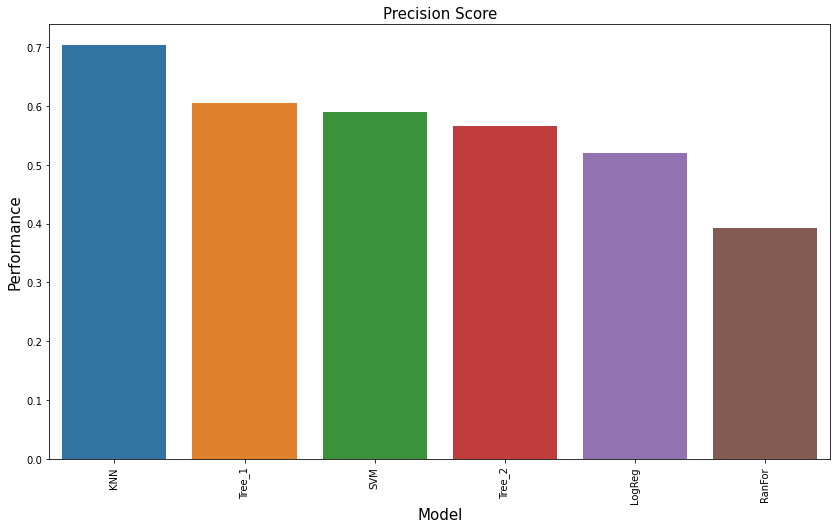

In [180]:
f, ax = plt.subplots(figsize=(14,8))
plt.xticks(rotation='90')
sns.barplot(x=sorted_result['Model'], y=sorted_result['Score'])
plt.xlabel('Model', fontsize=15)
plt.ylabel('Performance', fontsize=15)
#plt.ylim(0.10, 0.12)
plt.title('Precision Score', fontsize=15)
plt.show()

## Recall Score

In [181]:
knn_recall_score = round(recall_score(y_test, knn_yhat, average='macro'), 3)
tree1_recall_score = recall_score(y_test, tree_yhat, average='macro')
tree2_recall_score = recall_score(y_test, tree_yhat2, average='macro')
svm_recall_score = recall_score(y_test, SVM_yhat, average='macro')
logreg_recall_score = recall_score(y_test, logreg_yhat, average='macro')
ranfor_recall_score = recall_score(y_test, RanFor_yhat, average='macro')

In [182]:
results = pd.DataFrame({
    'Model':['KNN',
             'Tree_1',
            'Tree_2',
            'SVM',
             'LogReg',
             'RanFor'
            ],
    
    'Score':[knn_recall_score,
             tree1_recall_score,
             tree2_recall_score,
             svm_recall_score,
             logreg_recall_score,
            ranfor_recall_score
            ]})

sorted_result = results.sort_values(by='Score', ascending=False).reset_index(drop=True)
sorted_result.round(2)

,Model,Score
0,KNN,0.70
1,Tree_1,0.65
2,SVM,0.57
3,Tree_2,0.53
4,LogReg,0.51
5,RanFor,0.50


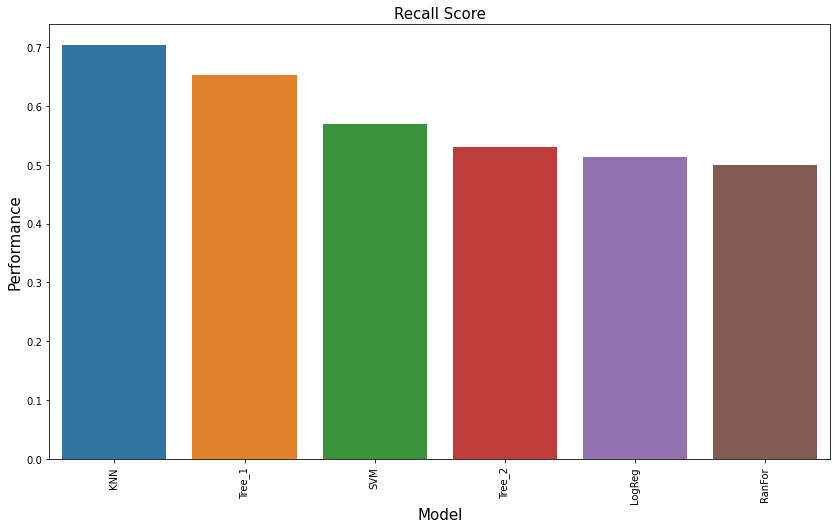

In [183]:
f, ax = plt.subplots(figsize=(14,8))
plt.xticks(rotation='90')
sns.barplot(x=sorted_result['Model'], y=sorted_result['Score'])
plt.xlabel('Model', fontsize=15)
plt.ylabel('Performance', fontsize=15)
#plt.ylim(0.10, 0.12)
plt.title('Recall Score', fontsize=15)
plt.show()

# Report

According to the above evaluation, the KNN model records the higher score among the tested models with different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


In [188]:
results = {
    'Accuracy':[knn_accuracy_score,
             tree1_accuracy_score,
             tree2_accuracy_score,
             svm_accuracy_score,
             logreg_accuracy_score,
            ranfor_accuracy_score],
            
    'Jaccard':[knn_jaccard_score,
             tree1_jaccard_score,
             tree2_jaccard_score,
             svm_jaccard_score,
             logreg_jaccard_score,
            ranfor_jaccard_score],
    
    'F1':[knn_f1_score,
             tree1_f1_score,
             tree2_f1_score,
             svm_f1_score,
             logreg_f1_score,
            ranfor_f1_score],
    
   'Precision':[knn_precision_score,
             tree1_precision_score,
             tree2_precision_score,
             svm_precision_score,
             logreg_precision_score,
            ranfor_precision_score],
    
    'Recall':[knn_recall_score,
             tree1_recall_score,
             tree2_recall_score,
             svm_recall_score,
             logreg_recall_score,
            ranfor_recall_score]
        }

In [196]:
results_df = pd.DataFrame.from_dict(results,
                          columns=['KNN', 'Tree_1', 'Tree_2', 'SVM', 'LogReg', 'RanFor'],
                          orient='index')

results_df.T.round(2)

,Accuracy,Jaccard,F1,Precision,Recall
KNN,0.80,0.57,0.70,0.70,0.70
Tree_1,0.64,0.43,0.59,0.60,0.65
Tree_2,0.76,0.43,0.52,0.57,0.53
SVM,0.74,0.45,0.57,0.59,0.57
LogReg,0.73,0.41,0.51,0.52,0.51
RanFor,0.79,0.39,0.44,0.39,0.50


In [197]:
# Now we can sort the score values by ecah evaluation matrics.

In [203]:
results_df.T.round(2).sort_values(by='F1', ascending=False)

,Accuracy,Jaccard,F1,Precision,Recall
KNN,0.80,0.57,0.70,0.70,0.70
Tree_1,0.64,0.43,0.59,0.60,0.65
SVM,0.74,0.45,0.57,0.59,0.57
Tree_2,0.76,0.43,0.52,0.57,0.53
LogReg,0.73,0.41,0.51,0.52,0.51
RanFor,0.79,0.39,0.44,0.39,0.50


In [204]:
results_df.T.round(2).sort_values(by='Recall', ascending=False)

,Accuracy,Jaccard,F1,Precision,Recall
KNN,0.80,0.57,0.70,0.70,0.70
Tree_1,0.64,0.43,0.59,0.60,0.65
SVM,0.74,0.45,0.57,0.59,0.57
Tree_2,0.76,0.43,0.52,0.57,0.53
LogReg,0.73,0.41,0.51,0.52,0.51
RanFor,0.79,0.39,0.44,0.39,0.50


##### By: Ramy Abdallah
PhD candidate working on Reducing uncertainty of subsurface interpretation in fold-thrust models from outcrops to machine learning.

***Thank You***